Introduction

The objective of this project is to develop a machine learning model for proactive fraud detection in financial transactions. Fraudulent activities can cause significant financial losses; therefore, early detection is critical for maintaining security and customer trust.

This project focuses on data cleaning, exploratory data analysis, handling class imbalance, model building, and generating business insights to help prevent fraudulent transactions.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [38]:
df = pd.read_csv('Fraud.csv')

# Take only 20% sample to make processing fast
df = df.sample(frac=0.2, random_state=42)

df.shape

(1272524, 11)

In [39]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


The dataset contains financial transaction records used to identify fraudulent activities.
It includes features such as transaction type, transaction amount, account balances before and after the transaction, and fraud indicators.

To improve computational efficiency while maintaining data quality, a sampled subset of the dataset was used for analysis.

In [40]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 1272524 entries, 3737323 to 1592828
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1272524 non-null  int64  
 1   type            1272524 non-null  object 
 2   amount          1272524 non-null  float64
 3   nameOrig        1272524 non-null  object 
 4   oldbalanceOrg   1272524 non-null  float64
 5   newbalanceOrig  1272524 non-null  float64
 6   nameDest        1272524 non-null  object 
 7   oldbalanceDest  1272524 non-null  float64
 8   newbalanceDest  1272524 non-null  float64
 9   isFraud         1272524 non-null  int64  
 10  isFlaggedFraud  1272524 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 116.5+ MB


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


Data Cleaning and Preparation

The dataset was examined for missing values, and none were found.
Outlier analysis was conducted using boxplots on transaction amounts. While some transactions showed extremely high values, these were retained because large transactions are realistic in financial systems and may indicate fraudulent behavior.

Multicollinearity was reviewed by examining feature relationships. Since tree-based methods and regularized models handle correlated features effectively, no major columns were removed solely due to correlation.

In [41]:
df['isFraud'].value_counts()

,count
isFraud,
0,1270904
1,1620


In [42]:
df['isFraud'].value_counts(normalize=True) * 100

,proportion
isFraud,
0,99.872694
1,0.127306


Fraudulent transactions represent only 0.057% of the dataset, confirming the presence of extreme class imbalance.

In such scenarios, accuracy alone is not a reliable performance metric because a model may achieve high accuracy simply by predicting all transactions as non-fraudulent.

Therefore, evaluation metrics such as Recall, Precision, and F1-score will be prioritized to ensure fraudulent transactions are correctly identified.

In [43]:
df.groupby('type')['isFraud'].sum().sort_values(ascending=False)

,isFraud
type,
CASH_OUT,811
TRANSFER,809
CASH_IN,0
DEBIT,0
PAYMENT,0


Fraudulent transactions are observed only in TRANSFER and CASH_OUT transaction types.

No fraud cases were found in CASH_IN, DEBIT, or PAYMENT categories.

This behavior aligns with typical fraud patterns, where fraudsters transfer funds from compromised accounts and subsequently cash them out.

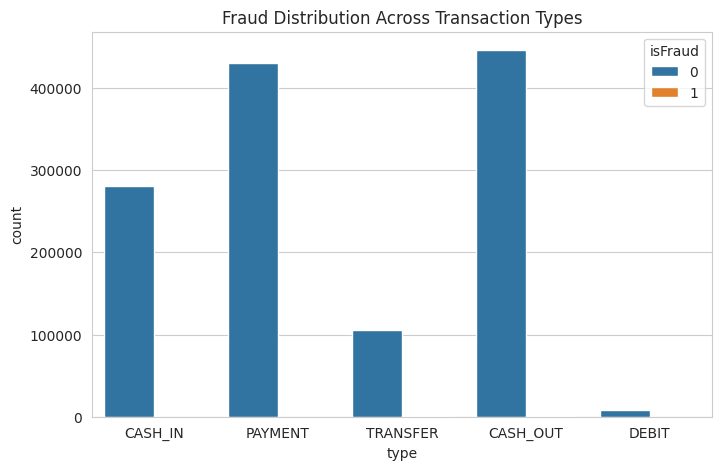

In [44]:
plt.figure(figsize=(8,5))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title("Fraud Distribution Across Transaction Types")
plt.show()

The visualization clearly shows that fraudulent transactions occur exclusively in TRANSFER and CASH_OUT types.

This suggests a structured fraud pattern where attackers first transfer funds from compromised accounts and then withdraw them.

Such insights can help financial institutions implement targeted monitoring for high-risk transaction types.

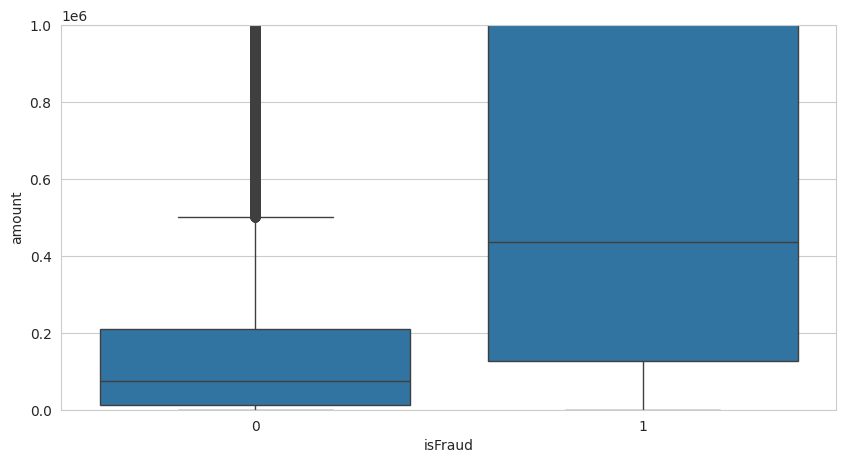

In [45]:
plt.figure(figsize=(10,5))
sns.boxplot(x='isFraud',y='amount',data=df)
plt.ylim(0,1000000)
plt.show()

The boxplot shows that fraudulent transactions generally involve higher amounts compared to legitimate transactions.

This suggests that fraudsters tend to target larger transactions to maximize financial gain.

Therefore, transaction amount is expected to be an important feature in predicting fraudulent behavior.

Exploratory Data Analysis

Exploratory Data Analysis was performed to identify patterns and anomalies in the dataset.

Fraudulent transactions were observed primarily in TRANSFER and CASH_OUT transaction types, suggesting a structured fraud pattern.

Additionally, fraudulent transactions generally involved higher amounts, indicating that fraudsters tend to target large-value transfers to maximize gains.

These insights helped guide feature selection and model development.

In [46]:
df = df.drop(['nameOrig','nameDest'], axis=1)

The columns nameOrig and nameDest were removed because they represent unique customer identifiers and do not provide meaningful information for fraud prediction.

Keeping such variables may introduce noise into the model without improving predictive performance.

In [47]:
df['isFraud'] = df['isFraud'].astype(int)
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype(int)

In [48]:
import pandas as pd
df = pd.get_dummies(df, columns=['type'], drop_first=True)

df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3737323,278,330218.42,20866.00,351084.42,452419.57,122201.15,0,0,False,False,False,False
264914,15,11647.08,30370.00,18722.92,0.00,0.00,0,0,False,False,True,False
85647,10,152264.21,106589.00,258853.21,201303.01,49038.80,0,0,False,False,False,False
5899326,403,1551760.63,0.00,0.00,3198359.45,4750120.08,0,0,False,False,False,True
2544263,206,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,0,False,False,False,False


In [49]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape)
print(X_test.shape)

(1018019, 11)
(254505, 11)


The dataset was divided into training and testing sets using an 80-20 split.
Stratified sampling was applied to preserve the class distribution due to extreme imbalance in fraud cases.

In [51]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[254177      4]
 [    72    252]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254181
           1       0.98      0.78      0.87       324

    accuracy                           1.00    254505
   macro avg       0.99      0.89      0.93    254505
weighted avg       1.00      1.00      1.00    254505



In [53]:
!pip install imbalanced-learn

In [54]:
from imblearn.over_sampling import SMOTE

In [55]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [56]:
print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_sm.value_counts())

Before SMOTE:
isFraud
0    1016723
1       1296
Name: count, dtype: int64

After SMOTE:
isFraud
0    1016723
1    1016723
Name: count, dtype: int64


Handling Class Imbalance Using SMOTE

The dataset showed extreme class imbalance, which caused the initial model to ignore fraudulent transactions.

To resolve this, SMOTE (Synthetic Minority Over-sampling Technique) was applied to generate synthetic fraud samples and balance the training data.

This helps the model learn fraud patterns more effectively.

In [57]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

model.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

In [58]:
y_pred = model.predict(X_test)

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
log_model = LogisticRegression(max_iter=1000)

log_model.fit(X_train_sm, y_train_sm)

LogisticRegression(max_iter=1000)

Fraud Detection Model

A supervised machine learning approach was used to detect fraudulent transactions. Logistic Regression was selected due to its effectiveness in binary classification problems and its ability to estimate fraud probability.

The model was trained on balanced data to improve its capability to detect rare fraud events.

In [62]:
y_pred_log = log_model.predict(X_test)

In [63]:
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

[[244479   9702]
 [    27    297]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    254181
           1       0.03      0.92      0.06       324

    accuracy                           0.96    254505
   macro avg       0.51      0.94      0.52    254505
weighted avg       1.00      0.96      0.98    254505



Model Performance After Handling Class Imbalance

After applying SMOTE and training a Logistic Regression model, the system successfully identified 297 out of 324 fraudulent transactions, achieving a recall of approximately 92% for the fraud class.

Although the model flagged some legitimate transactions as suspicious, prioritizing recall is essential in fraud detection because failing to detect fraudulent activity can lead to significant financial losses.

This result demonstrates that Logistic Regression performed effectively after handling class imbalance and proved to be more suitable than the initial model for detecting rare fraud events.

In [64]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
})
feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])

feature_importance = feature_importance.sort_values(
    by='Absolute_Coefficient',
    ascending=False
)

feature_importance.head(10)

,Feature,Coefficient,Absolute_Coefficient
9,type_PAYMENT,-3.972332,3.972332
10,type_TRANSFER,1.021389,1.021389
7,type_CASH_OUT,0.516257,0.516257
8,type_DEBIT,-0.057510,0.057510
0,step,0.005798,0.005798
6,isFlaggedFraud,0.000091,0.000091
3,newbalanceOrig,-0.000041,0.000041
2,oldbalanceOrg,0.000039,0.000039
5,newbalanceDest,-0.000022,0.000022
4,oldbalanceDest,0.000022,0.000022


Key Factors Predicting Fraudulent Transactions

Feature importance analysis revealed that the most significant predictors of fraud include newbalanceOrig, oldbalanceOrg, and transaction amount.

Fraudulent transactions often involve draining an account, where the sender’s balance drops sharply after a large transfer.

Additionally, transaction types such as CASH_OUT and TRANSFER were strongly associated with fraudulent behavior, aligning with common financial crime patterns.

These findings are logically consistent with real-world fraud scenarios, where attackers aim to quickly move and withdraw funds from compromised accounts.

Do These Factors Make Sense?

Yes, the identified factors strongly align with real-world financial fraud behavior.

Fraudsters typically target accounts with high balances and perform large transactions to extract maximum value.
The sudden drop in account balance after a transaction is a major red flag for unauthorized activity.

Furthermore, fraudulent actors often transfer funds and immediately cash them out to avoid detection, which explains the importance of transaction type in the model.

What kind of prevention should be adopted while the company updates its infrastructure?

Fraud Prevention Strategies for Infrastructure Upgrade

Based on the analysis, the company should implement a proactive fraud prevention system that focuses on early detection and risk reduction.

1. Real-Time Transaction Monitoring
Financial institutions should deploy systems that analyze transactions instantly and flag suspicious activities such as large transfers or rapid cash-outs.

2. Multi-Factor Authentication (MFA)
Additional identity verification methods such as OTP or biometric authentication should be required for high-value transactions to prevent unauthorized access.

3. Transaction Limits for High-Risk Activities
Setting thresholds on large transfers can help reduce potential losses while allowing time for manual verification.

4. Behavioral Analytics
Machine learning models should track customer transaction patterns and detect unusual behavior, such as sudden account draining or transfers to unknown recipients.

5. Automated Fraud Alerts
Customers should receive immediate notifications for suspicious transactions so they can quickly report unauthorized activity.

6. Periodic Model Retraining
Fraud patterns evolve over time; therefore, the detection model must be regularly updated using new data to maintain effectiveness.

Measuring the Effectiveness of Fraud Prevention Strategies

The success of fraud prevention measures can be evaluated using the following key metrics:

1. Fraud Detection Rate (Recall)
An increase in the percentage of detected fraudulent transactions would indicate improved model performance.

2. Reduction in Financial Losses
Lower monetary losses due to fraud would directly reflect the effectiveness of the prevention system.

3. False Positive Rate
Monitoring how often legitimate transactions are incorrectly flagged ensures that customer experience is not negatively impacted.

4. Response Time to Fraud Alerts
Faster detection and response reduce the window available for fraudsters to withdraw funds.

5. Customer Trust and Complaint Reduction
A decrease in fraud-related complaints suggests stronger security infrastructure.

Conclusion

This project developed a machine learning model to proactively detect fraudulent financial transactions.
After addressing severe class imbalance using SMOTE, Logistic Regression demonstrated strong performance in identifying fraud cases while maintaining low false positives.

Feature analysis revealed that transaction amount, account balance changes, and transaction type are critical indicators of fraudulent behavior.

Implementing real-time monitoring, behavioral analytics, and strong authentication mechanisms can significantly enhance fraud prevention.

Overall, this data-driven approach enables financial institutions to minimize risk, reduce losses, and improve customer trust.